# Projet cours : données localisation

In [1]:
!pip install scikeras

In [2]:
!pip install --upgrade scikit-learn

In [3]:
!pip install scikeras

In [4]:
import os
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from pandas import read_csv
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
import sklearn.metrics

from keras.models import Sequential, Model
from keras.layers import (
    Dense, Dropout, Conv1D, Flatten, MaxPooling1D, 
    Add, AveragePooling1D, BatchNormalization, 
    Activation, Input)

from keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier


Mount google drive:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd  /content/drive/MyDrive
%mkdir M2BI_DRIVE
%cd  /content/drive/MyDrive/M2BI_DRIVE
%pwd

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/M2BI_DRIVE


'/content/drive/MyDrive/M2BI_DRIVE'

In [5]:
def download_data():
    url="https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz"
    datasetFolderPath = "dataset/"
    file = "reduced_train.npz"
    FilePath = os.path.join(datasetFolderPath, file)
    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)


In [6]:
download_data()

dataset/reduced_train.npz: 100%|██████████| 8.52M/8.52M [00:00<00:00, 28.6MB/s]


In [7]:
# Data treatment
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X")
print(X_train.shape)
print("Shape of dataset Y")
print(Y.shape)
print("Shape of dataset Mask")
print(mask_train.shape)
classes = preprocessing.LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = to_categorical(classes_Y)

print("First 5 rows of X_train:\n", X_train[:5])
print("First 5 elements of Y (original):\n", Y[:5])
print("First 5 rows of mask_train:\n", mask_train[:5])

print("First 5 rows of one-hot encoded Y:\n", onehot_Y[:5])


Shape of dataset X
(2423, 400, 20)
Shape of dataset Y
(2423,)
Shape of dataset Mask
(2423, 400)
First 5 rows of X_train:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.  

In [ ]:
len(set(classes_Y))

10

In [8]:
X_train_cut, X_test, y_train, y_test = train_test_split(X_train, onehot_Y, test_size=0.2, random_state=3, shuffle=True)

In [11]:
print(len(y_train))
print(len(y_test))
print(X_train_cut.shape)
print(X_test.shape)

1938
485
(1938, 400, 20)
(485, 400, 20)


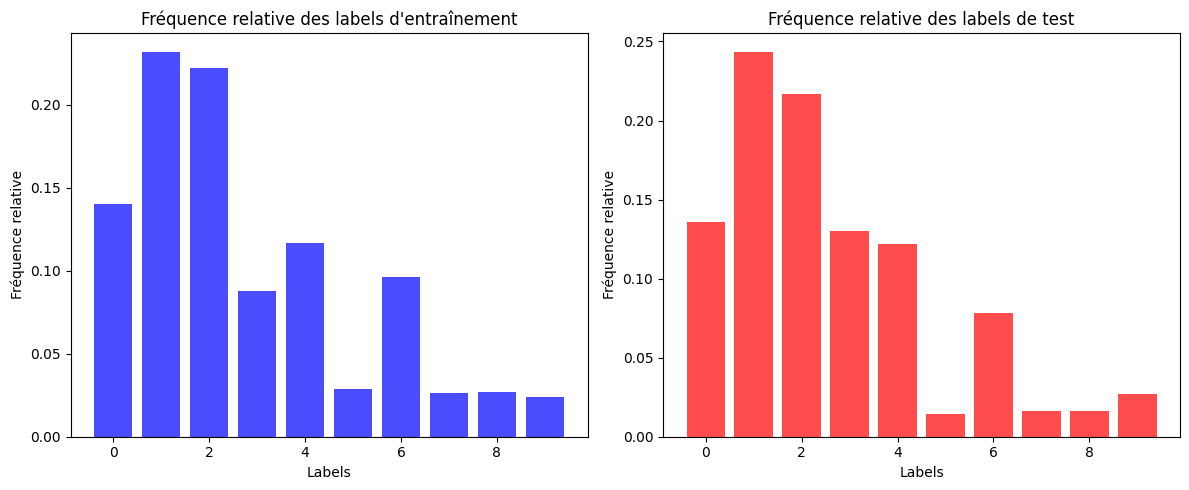

In [ ]:
# Calculate relative frequencies for training labels
train_unique, train_counts = np.unique(np.argmax(y_train,axis = 1), return_counts=True)
train_freq = train_counts / len(np.argmax(y_train,axis = 1))

# Calculate relative frequencies for test labels
test_unique, test_counts = np.unique(np.argmax(y_test,axis = 1), return_counts=True)
test_freq = test_counts / len(np.argmax(y_test,axis = 1))

# Initialize figure
plt.figure(figsize=(12, 5))

# Relative frequency distribution of training labels
plt.subplot(1, 2, 1)
plt.bar(train_unique, train_freq, color='blue', alpha=0.7)
plt.title('Fréquence relative des labels d\'entraînement')
plt.xlabel('Labels')
plt.ylabel('Fréquence relative')

# Relative frequency distribution of test labels
plt.subplot(1, 2, 2)
plt.bar(test_unique, test_freq, color='red', alpha=0.7)
plt.title('Fréquence relative des labels de test')
plt.xlabel('Labels')
plt.ylabel('Fréquence relative')

# Show distributions
plt.tight_layout()
plt.show()

## Convolutional Network

In [15]:
def cnn_simple():
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', input_shape=(400, 20), kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten and add Dropout to reduce overlearning
    model.add(Flatten())
    model.add(Dropout(0.4))  

    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.4))  

    model.add(Dense(10, activation='softmax'))

    # Model compilation
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)                   │ (None, 398, 64)             │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_72 (MaxPooling1D)      │ (None, 199, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 197, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_73 (MaxPooling1D)      │ (None, 98, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_74 (Conv1D)                   │ (None, 96, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_74 (MaxPooling1D)      │ (None, 48, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 32)                  │         393,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 520,746 (1.99 MB)

 Trainable params: 520,746 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

None


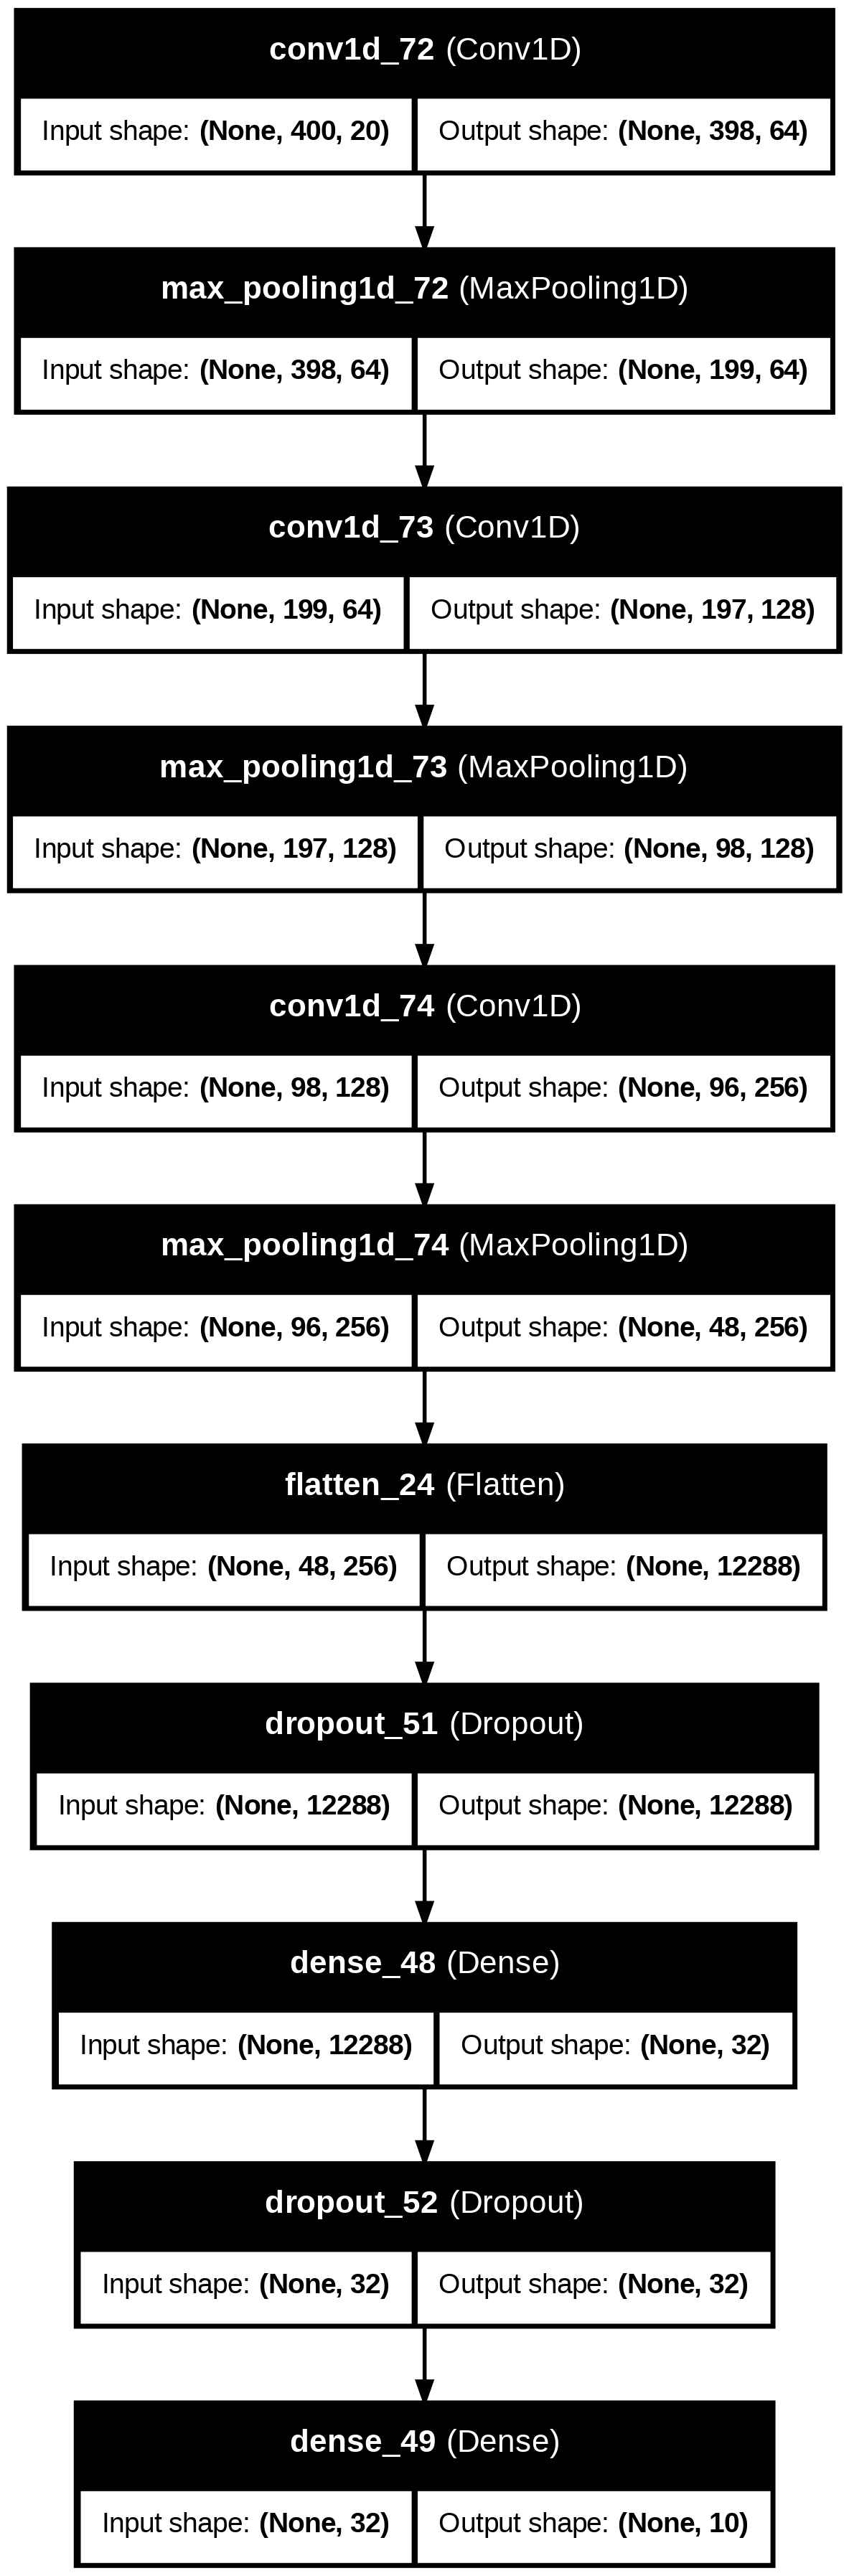

In [ ]:
model_cnn = cnn_simple()
print(f'{model_cnn.summary()}')
plot_model(model_cnn, to_file="model_cnn.png",
               show_shapes=True, show_layer_names=True)

In [ ]:
y_train_integers = np.argmax(y_train, axis=1)
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Convert to dictionary {class: weight}
class_weights_dict = dict(enumerate(class_weights))


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn = model_cnn.fit(X_train_cut, y_train, validation_split=0.2, epochs=50, batch_size=64,
                            callbacks=[early_stopping],
                            class_weight=class_weights_dict)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 327ms/step - accuracy: 0.0815 - loss: 3.3629 - weighted_accuracy: 0.1057 - val_accuracy: 0.1057 - val_loss: 3.2191 - val_weighted_accuracy: 0.1057
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1233 - loss: 3.2549 - weighted_accuracy: 0.1422 - val_accuracy: 0.1546 - val_loss: 3.1942 - val_weighted_accuracy: 0.1546
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1320 - loss: 3.0922 - weighted_accuracy: 0.1552 - val_accuracy: 0.1881 - val_loss: 3.1283 - val_weighted_accuracy: 0.1881
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1379 - loss: 3.1521 - weighted_accuracy: 0.1733 - val_accuracy: 0.2552 - val_loss: 3.0635 - val_weighted_accuracy: 0.2552
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2095 - loss: 3.0397 - weighted_accuracy: 0.2333 - val_accuracy: 0.2732 - val_loss: 2.9924 - val_weighted_accuracy: 0.2732
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


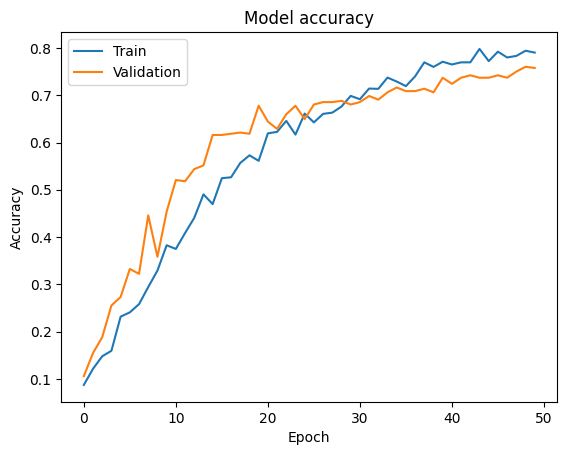

In [ ]:
print(history_cnn.history.keys())
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


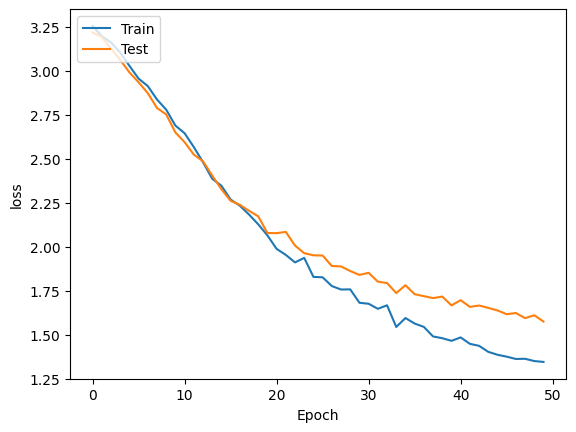

In [ ]:
print(history_cnn.history.keys())
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
#plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model_cnn.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7979 - loss: 1.4957 - weighted_accuracy: 0.7979


[1.486433982849121, 0.7917525768280029, 0.7917525768280029, 0.7917525768280029]

In [ ]:
y_predcnn = model_cnn.predict(X_test)
y_predcnn_classes = np.argmax(y_predcnn,axis = 1)
y_classes = np.argmax(y_test,axis = 1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Axes: >

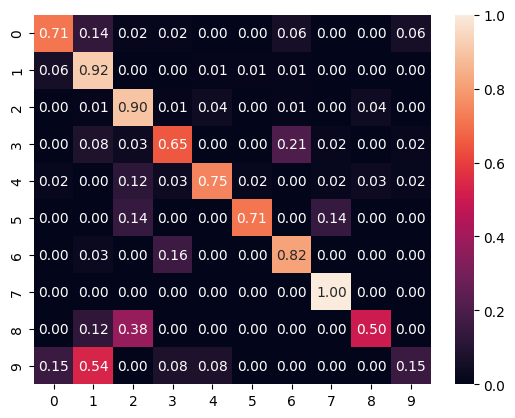

In [ ]:
sns.heatmap(sklearn.metrics.confusion_matrix(y_classes, y_predcnn_classes, normalize="true"), fmt=".2f", annot=True)

## Cross validation

In [16]:
# Cross validation
# Variables to store the best model and precision
models_fold = []
fold_val_losses = []
fold_val_accuracies = []
fold_train_losses = []
fold_train_accuracies = []
not_all_val_losses = []
not_all_val_accuracies = []
not_all_train_losses = []
not_all_train_accuracies = []

# KFold configuration
kfold = KFold(n_splits=5, shuffle=True)

# Fold course
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_cut)):
    print(f"Fold {fold+1}")

    model = cnn_simple()

    # Separate training and validation data for this fold
    X_fold_train, X_fold_val = X_train_cut[train_idx], X_train_cut[val_idx]
    Y_fold_train, Y_fold_val = y_train[train_idx], y_train[val_idx]

    # class weight
    y_train_integers = np.argmax(Y_fold_train, axis=1)
    # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',  
        classes=np.unique(y_train_integers),
        y=y_train_integers
    )

    class_weights_dict = dict(enumerate(class_weights))

    history = model.fit(X_fold_train, Y_fold_train, validation_data=(X_fold_val, Y_fold_val),
                        epochs=50, batch_size=64,
                        class_weight=class_weights_dict,
                        verbose=0)

    # Evaluation of validation data
    res_eval = model.evaluate(X_fold_val, Y_fold_val, verbose=0)
    val_loss, val_accuracy = res_eval[0], res_eval[1]

    print(f"Fold {fold+1} - Validation Accuracy: {val_accuracy:.4f}")

    models_fold.append(model)

    # Save losses and details for this fold
    fold_train_losses.append(history.history['loss'])
    fold_train_accuracies.append(history.history['accuracy'])
    fold_val_losses.append(history.history['val_loss'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    not_all_train_losses.append(history.history['loss'][-1])
    not_all_train_accuracies.append(history.history['accuracy'][-1])
    not_all_val_losses.append(history.history['val_loss'][-1])
    not_all_val_accuracies.append(history.history['val_accuracy'][-1])


Fold 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - Validation Accuracy: 0.8119
Fold 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 - Validation Accuracy: 0.7887
Fold 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 - Validation Accuracy: 0.7629
Fold 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 - Validation Accuracy: 0.7804
Fold 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 - Validation Accuracy: 0.7494


### Analyse

In [17]:
mean_total_loss = np.mean(not_all_val_losses)
mean_total_accuracy = np.mean(not_all_val_accuracies)
std_val_loss = np.std(not_all_val_losses)
std_val_accuracy = np.std(not_all_val_accuracies)
print(f"Mean val losses: {mean_total_loss}")
print(f"Mean val accuracies: {mean_total_accuracy}")
print(f"Std val losses: {std_val_loss}")
print(f"Std val accuracies: {std_val_accuracy}")

mean_total_loss = np.mean(not_all_train_losses)
mean_total_accuracy = np.mean(not_all_train_accuracies)
std_train_loss = np.std(not_all_train_losses)
std_train_accuracy = np.std(not_all_train_accuracies)
print(f"Mean train losses: {mean_total_loss}")
print(f"Mean train accuracies: {mean_total_accuracy}")
print(f"Std train losses: {std_train_loss}")
print(f"Std train accuracies: {std_train_accuracy}")

Mean val losses: 1.5451955795288086
Mean val accuracies: 0.7786235690116883
Std val losses: 0.0467201721934416
Std val accuracies: 0.02150572193092119
Mean train losses: 1.3420804738998413
Mean train accuracies: 0.7987662434577942
Std train losses: 0.04922967970942871
Std train accuracies: 0.02481227324922105


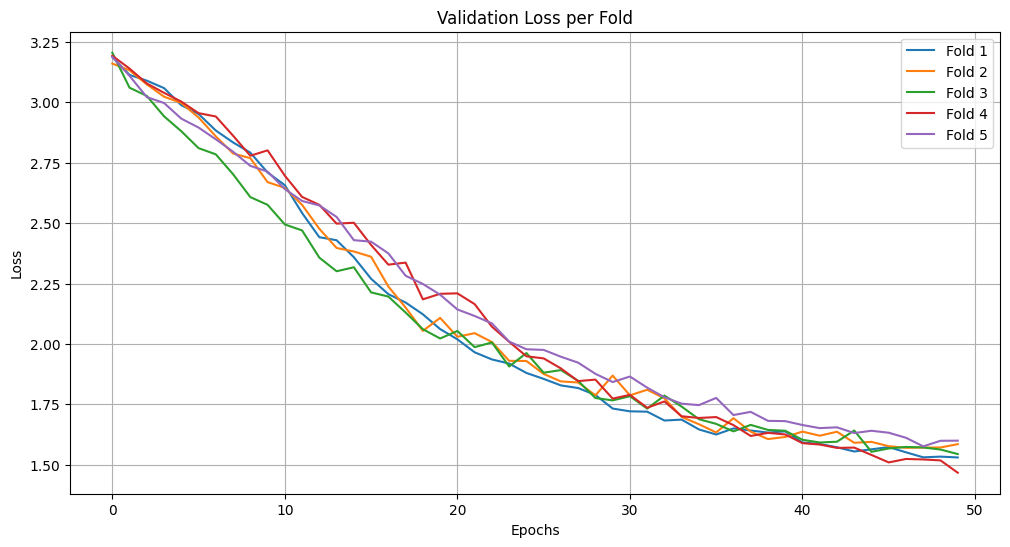

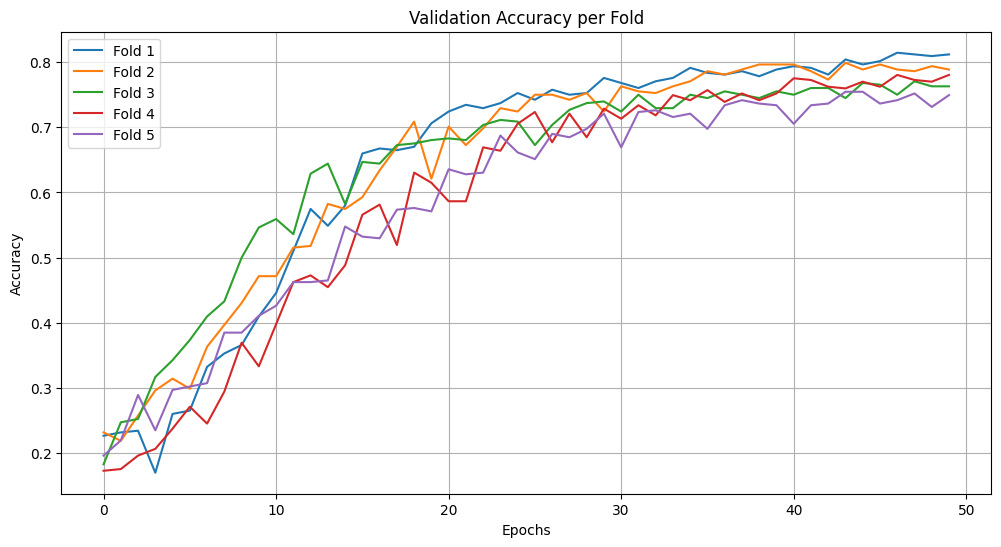

In [18]:
# Trace losses
plt.figure(figsize=(12, 6))

# Validation curves for each fold
for i in range(len(fold_val_losses)):
    plt.plot(fold_val_losses[i], label=f'Fold {i+1}')

plt.title('Validation Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Tracing precision
plt.figure(figsize=(12, 6))

# Precision curves for each fold
for i in range(len(fold_val_accuracies)):
    plt.plot(fold_val_accuracies[i], label=f'Fold {i+1}')

plt.title('Validation Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

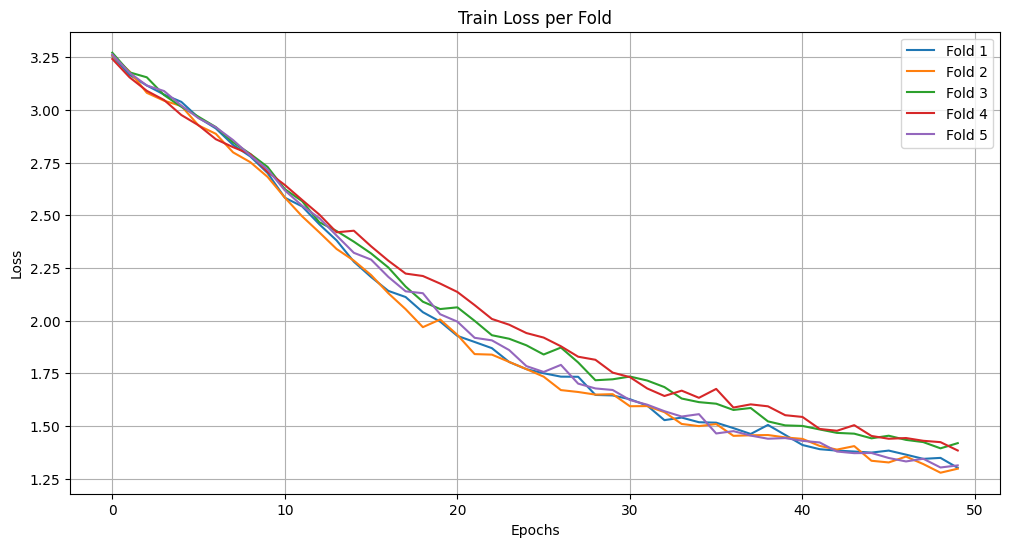

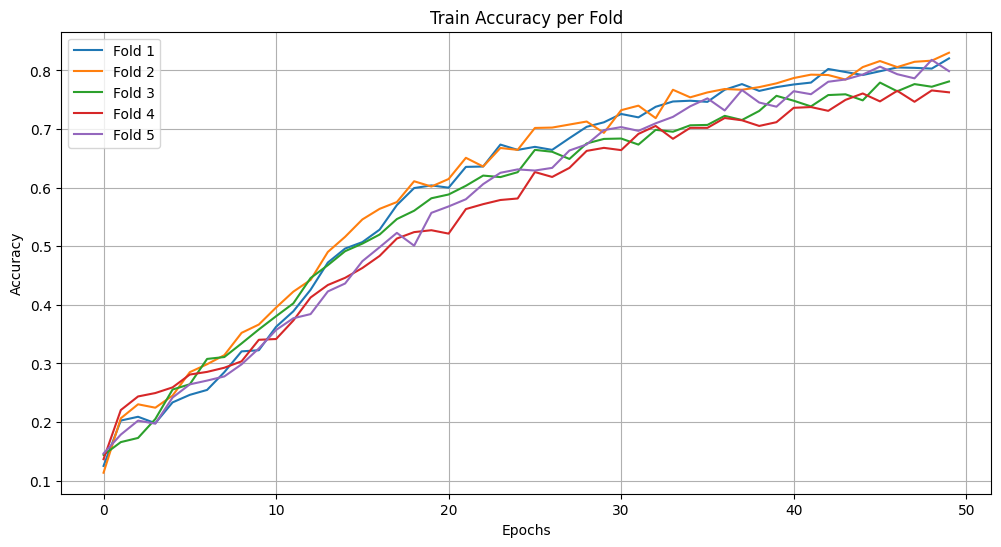

In [19]:
# Trace losses
plt.figure(figsize=(12, 6))

# Validation curves for each fold
for i in range(len(fold_train_losses)):
    plt.plot(fold_train_losses[i], label=f'Fold {i+1}')

plt.title('Train Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Tracing precision
plt.figure(figsize=(12, 6))

# Precision curves for each fold
for i in range(len(fold_train_accuracies)):
    plt.plot(fold_train_accuracies[i], label=f'Fold {i+1}')

plt.title('Train Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
test_models_accuracy = []
test_models_loss = []
for mod in models_fold:
    res = mod.evaluate(X_test,y_test)
    test_models_loss.append(res[0])
    test_models_accuracy.append(res[1])
print("Test models accuracy:", sum(test_models_accuracy)/len(test_models_accuracy))
print("Test models loss:", sum(test_models_loss)/len(test_models_loss))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7607 - loss: 1.5221 - weighted_accuracy: 0.7607
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7661 - loss: 1.5753 - weighted_accuracy: 0.7661
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7300 - loss: 1.5920 - weighted_accuracy: 0.7300
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7619 - loss: 1.5441 - weighted_accuracy: 0.7619
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7840 - loss: 1.5680 - weighted_accuracy: 0.7840
Test models accuracy: 0.7760824799537659
Test models loss: 1.5214159965515137


In [21]:
mean_accuracy = np.mean(test_models_accuracy)
std_accuracy = np.std(test_models_accuracy)

mean_loss = np.mean(test_models_loss)
std_loss = np.std(test_models_loss)

# Display results
print(f"Test models mean accuracy: {mean_accuracy * 100:.2f}% (± {std_accuracy * 100:.2f}%)")
print(f"Test models mean loss: {mean_loss:.4f} (± {std_loss:.4f})")

Test models mean accuracy: 77.61% (± 1.46%)
Test models mean loss: 1.5214 (± 0.0221)


In [22]:
print(test_models_accuracy)
print(test_models_loss)

[0.7793814539909363, 0.777319610118866, 0.7505154609680176, 0.777319610118866, 0.7958762645721436]
[1.512044906616211, 1.516680359840393, 1.5615508556365967, 1.4944496154785156, 1.522354245185852]


## Resnet

In [23]:
def residual_module(input, channels, dropout_rate=0.3, l2_lambda=0.05):
    stride = 1
    kernel_size = 3
    x_shortcut = input

    # First Conv + BatchNorm + Activation
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv1D(channels, (1), kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(dropout_rate)(x)

    # Second Conv + BatchNorm + Activation
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size, padding='same', strides=stride, kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(dropout_rate)(x)

    output = Add()([x, x_shortcut])
    return output


# Define the ResNet architecture
def resnet():
    """
    Creates a simple 1D Residual Network (ResNet) for classification tasks.
    This network stacks multiple residual blocks, followed by global average pooling and a dense output layer.

    Returns:
    Model: The complete ResNet model.
    """
    n_residual = 2  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    inputs = Input(shape=(400, 20))

    # Pass the input through the residual blocks
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, 20)

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D((2), strides=(1))(residual_i)
    gavg_1 = Dropout(0.3)(gavg_1)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    output = Dense(10, activation="softmax")(flat_1)

    # Define the model 
    model = Model(inputs=inputs, outputs=output)

    plot_model(model, to_file="residual.png", show_shapes=True, show_layer_names=True)

    print(model.summary())

    # Compile the model
    opt = optimizers.Adam(learning_rate=0.00005)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

# Create the ResNet model
model = resnet()


Simple residual network with 2 modules


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 400, 20)        │             80 │ input_layer_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 400, 20)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 400, 20)        │            420 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 400, 20)        │             80 │ dropout_10[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 400, 20)        │              0 │ dropout_11[0][0],      │
│                           │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 400, 20)        │             80 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 400, 20)        │             80 │ dropout_12[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)   

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None


In [10]:
y_train_integers = np.argmax(y_train, axis=1)
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    y=y_train_integers
)
class_weights_dict = dict(enumerate(class_weights))


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_resnet = model.fit(X_train_cut, y_train, validation_split=0.2, epochs=150, batch_size=32,
                           callbacks=[early_stopping], class_weight=class_weights_dict)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.1079 - loss: 6.9906 - weighted_accuracy: 0.0985 - val_accuracy: 0.0851 - val_loss: 6.2991 - val_weighted_accuracy: 0.0851
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1204 - loss: 6.8086 - weighted_accuracy: 0.1086 - val_accuracy: 0.0825 - val_loss: 6.2730 - val_weighted_accuracy: 0.0825
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1380 - loss: 6.7043 - weighted_accuracy: 0.1087 - val_accuracy: 0.0876 - val_loss: 6.2277 - val_weighted_accuracy: 0.0876
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.1625 - loss: 6.4368 - weighted_accuracy: 0.1680 - val_accuracy: 0.1160 - val_loss: 6.1903 - val_weighted_accuracy: 0.1160
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.2003 - loss: 6.3670 - weighted_accuracy: 0.2065 - val_accuracy: 0.1753 - val_loss: 6.1004 - val_weighted_accuracy: 0.1753
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accur

In [11]:
model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7561 - loss: 1.5488 - weighted_accuracy: 0.7561


[1.5853450298309326,
 0.7505154609680176,
 0.7505154609680176,
 0.7505154609680176]

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


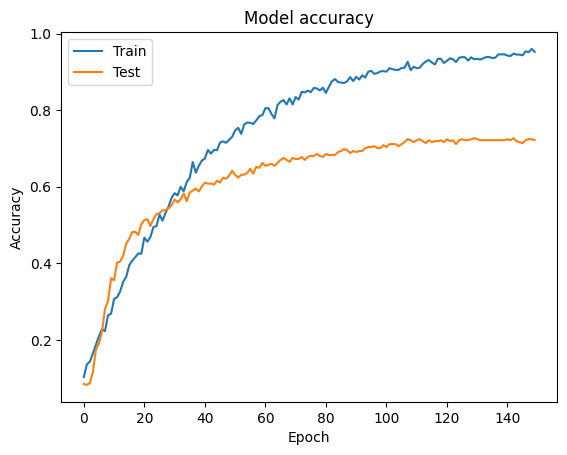

In [12]:
print(history_resnet.history.keys())
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


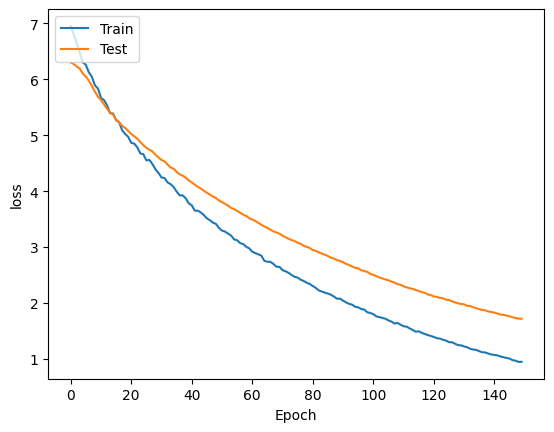

In [13]:
print(history_resnet.history.keys())
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


<Axes: >

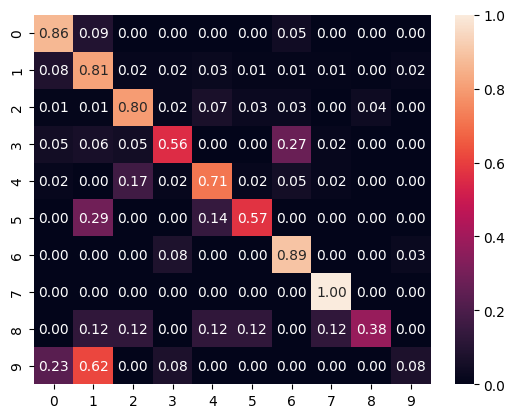

In [14]:
y_predresnet = model.predict(X_test)
y_predresnet_classes = np.argmax(y_predresnet,axis = 1)
y_classes = np.argmax(y_test,axis = 1)
sns.heatmap(sklearn.metrics.confusion_matrix(y_classes, y_predresnet_classes, normalize="true"), fmt=".2f", annot=True)

## Cross-validation

In [24]:
# Variables to store the best model and precision
models_fold = []
fold_val_losses = []
fold_val_accuracies = []
fold_train_losses = []
fold_train_accuracies = []
not_all_val_losses = []
not_all_val_accuracies = []
not_all_train_losses = []
not_all_train_accuracies = []

# KFold configuration
kfold = KFold(n_splits=5, shuffle=True)

# Fold course
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_cut)):
    print(f"Fold {fold+1}")

    model = resnet()

    X_fold_train, X_fold_val = X_train_cut[train_idx], X_train_cut[val_idx]
    Y_fold_train, Y_fold_val = y_train[train_idx], y_train[val_idx]

    y_train_integers = np.argmax(y_train, axis=1)

    class_weights = class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train_integers),
        y=y_train_integers
    )
    class_weights_dict = dict(enumerate(class_weights))

    history = model.fit(X_fold_train, Y_fold_train,
                        validation_data=(X_fold_val, Y_fold_val),
                        epochs=150, batch_size=32,
                        class_weight=class_weights_dict,
                        verbose=0)

    models_fold.append(model)

    fold_train_losses.append(history.history['loss'])
    fold_train_accuracies.append(history.history['accuracy'])
    fold_val_losses.append(history.history['val_loss'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    not_all_train_losses.append(history.history['loss'][-1])
    not_all_train_accuracies.append(history.history['accuracy'][-1])
    not_all_val_losses.append(history.history['val_loss'][-1])
    not_all_val_accuracies.append(history.history['val_accuracy'][-1])


Fold 1
Simple residual network with 2 modules


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 400, 20)        │             80 │ input_layer_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 400, 20)        │             80 │ dropout_15[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 400, 20)        │              0 │ dropout_16[0][0],      │
│                           │                        │                │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 400, 20)        │             80 │ add_2[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 400, 20)        │             80 │ dropout_17[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)   

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None
Fold 2
Simple residual network with 2 modules


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 400, 20)        │             80 │ input_layer_7[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 400, 20)        │             80 │ dropout_20[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_9 (Activation) │ (None, 400, 20)        │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_9[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 400, 20)        │              0 │ dropout_21[0][0],      │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 400, 20)        │             80 │ add_4[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 400, 20)        │             80 │ dropout_22[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)         

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None
Fold 3
Simple residual network with 2 modules


Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 400, 20)        │             80 │ input_layer_8[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 400, 20)        │             80 │ dropout_25[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_28 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 400, 20)        │              0 │ dropout_26[0][0],      │
│                           │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 400, 20)        │             80 │ add_6[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_29 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 400, 20)        │             80 │ dropout_27[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None
Fold 4
Simple residual network with 2 modules


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 400, 20)        │             80 │ input_layer_9[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 400, 20)        │             80 │ dropout_30[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 400, 20)        │              0 │ dropout_31[0][0],      │
│                           │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 400, 20)        │             80 │ add_8[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 400, 20)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 400, 20)        │             80 │ dropout_32[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None
Fold 5
Simple residual network with 2 modules


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 400, 20)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 400, 20)        │             80 │ input_layer_10[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 400, 20)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_35 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 400, 20)        │             80 │ dropout_35[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 400, 20)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 400, 20)        │          1,220 │ activation_21[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 400, 20)        │              0 │ dropout_36[0][0],      │
│                           │                        │                │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 400, 20)        │             80 │ add_10[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_22             │ (None, 400, 20)        │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 400, 20)        │            420 │ activation_22[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 400, 20)        │              0 │ conv1d_37[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 400, 20)        │             80 │ dropout_37[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

None


In [25]:
mean_total_loss = np.mean(not_all_val_losses)
mean_total_accuracy = np.mean(not_all_val_accuracies)
std_val_loss = np.std(not_all_val_losses)
std_val_accuracy = np.std(not_all_val_accuracies)
print(f"Mean val losses: {mean_total_loss}")
print(f"Mean val accuracies: {mean_total_accuracy}")
print(f"Std val losses: {std_val_loss}")
print(f"Std val accuracies: {std_val_accuracy}")

mean_total_loss = np.mean(not_all_train_losses)
mean_total_accuracy = np.mean(not_all_train_accuracies)
std_train_loss = np.std(not_all_train_losses)
std_train_accuracy = np.std(not_all_train_accuracies)
print(f"Mean train losses: {mean_total_loss}")
print(f"Mean train accuracies: {mean_total_accuracy}")
print(f"Std train losses: {std_train_loss}")
print(f"Std train accuracies: {std_train_accuracy}")

Mean val losses: 1.6978368997573852
Mean val accuracies: 0.7399637818336486
Std val losses: 0.08960425803815676
Std val accuracies: 0.039246380629577256
Mean train losses: 0.9783883810043335
Mean train accuracies: 0.9464640140533447
Std train losses: 0.05463852205650459
Std train accuracies: 0.007342493061989272


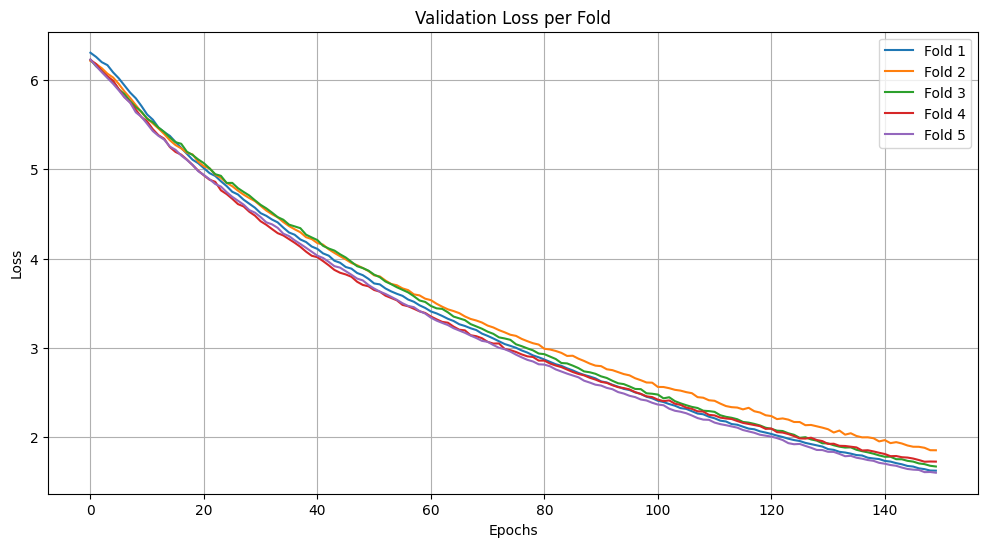

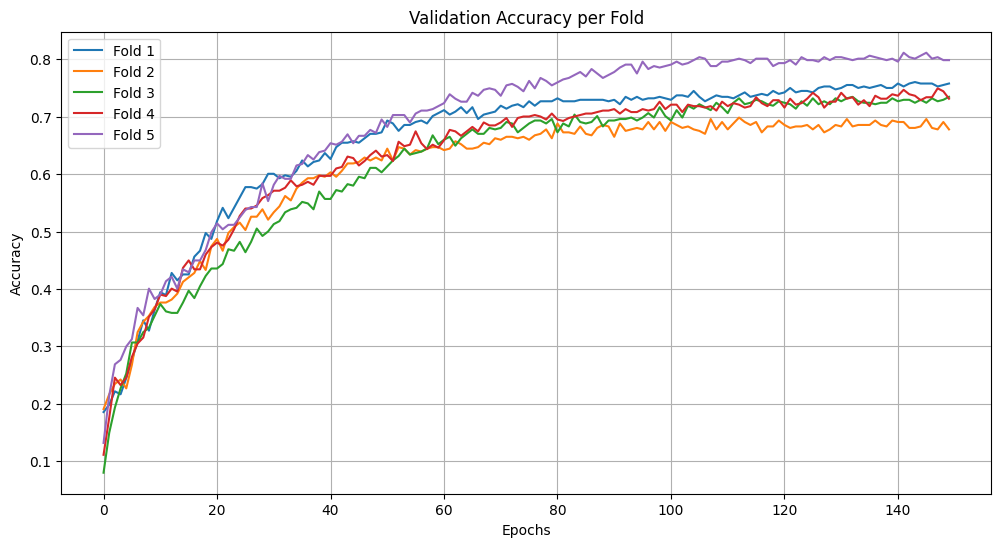

In [26]:
# Trace losses
plt.figure(figsize=(12, 6))

# Validation curves for each fold
for i in range(len(fold_val_losses)):
    plt.plot(fold_val_losses[i], label=f'Fold {i+1}')

plt.title('Validation Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Tracing precision
plt.figure(figsize=(12, 6))

# Precision curves for each fold
for i in range(len(fold_val_accuracies)):
    plt.plot(fold_val_accuracies[i], label=f'Fold {i+1}')

plt.title('Validation Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

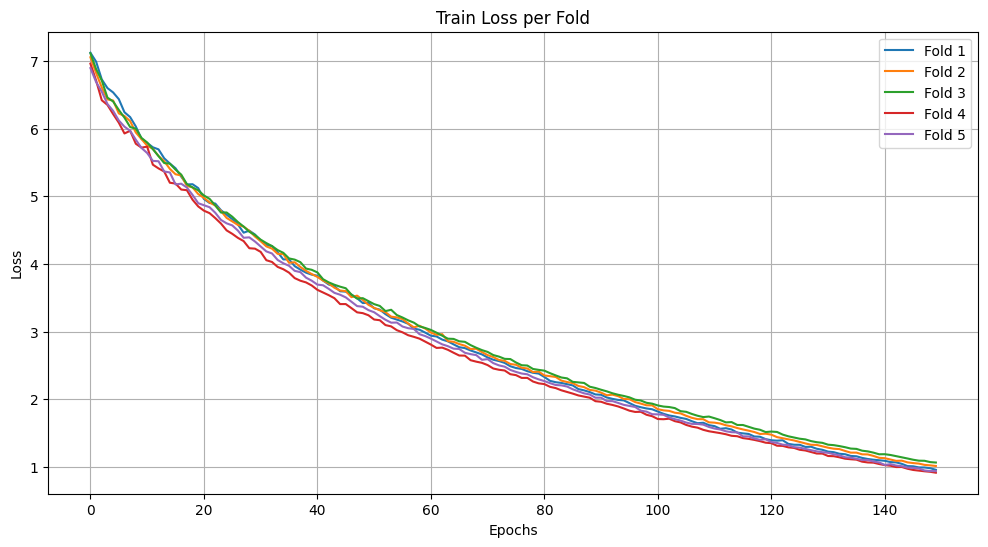

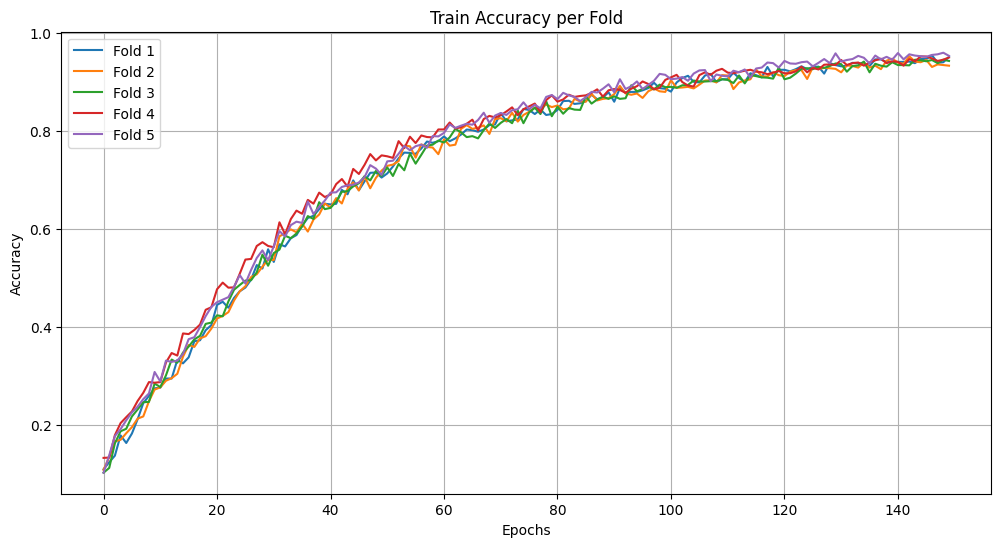

In [27]:
# Trace losses
plt.figure(figsize=(12, 6))

# Validation curves for each fold
for i in range(len(fold_train_losses)):
    plt.plot(fold_train_losses[i], label=f'Fold {i+1}')

plt.title('Train Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Tracing precision
plt.figure(figsize=(12, 6))

# Precision curves for each fold
for i in range(len(fold_train_accuracies)):
    plt.plot(fold_train_accuracies[i], label=f'Fold {i+1}')

plt.title('Train Accuracy per Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [28]:
test_models_accuracy = []
test_models_loss = []
for mod in models_fold:
    res = mod.evaluate(X_test,y_test)
    test_models_loss.append(res[0])
    test_models_accuracy.append(res[1])
print("Test models accuracy:", sum(test_models_accuracy)/len(test_models_accuracy))
print("Test models loss:", sum(test_models_loss)/len(test_models_loss))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7343 - loss: 1.6682 - weighted_accuracy: 0.7343
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7070 - loss: 1.8021 - weighted_accuracy: 0.7070
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7489 - loss: 1.6860 - weighted_accuracy: 0.7489
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7547 - loss: 1.5403 - weighted_accuracy: 0.7547
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7673 - loss: 1.5844 - weighted_accuracy: 0.7673
Test models accuracy: 0.7402061820030212
Test models loss: 1.6493361949920655


In [29]:
mean_accuracy = np.mean(test_models_accuracy)
std_accuracy = np.std(test_models_accuracy)

mean_loss = np.mean(test_models_loss)
std_loss = np.std(test_models_loss)

# Display results
print(f"Test models mean accuracy: {mean_accuracy * 100:.2f}% (± {std_accuracy * 100:.2f}%)")
print(f"Test models mean loss: {mean_loss:.4f} (± {std_loss:.4f})")

Test models mean accuracy: 74.02% (± 1.43%)
Test models mean loss: 1.6493 (± 0.0865)


In [30]:
print(test_models_accuracy)
print(test_models_loss)

[0.7298969030380249, 0.7278350591659546, 0.7340205907821655, 0.7422680258750916, 0.7670103311538696]
[1.6598100662231445, 1.7797086238861084, 1.6975716352462769, 1.5492531061172485, 1.5603375434875488]


Faire la moyenne des performance ou la moyenne - l'écart type pour montrer la robustesse du modèle et pour être sûr que c'est bien.

### Analyse statistique : comparaison